In [10]:
# use the nolearn environment (source activate nolearn) to run this notebook
# Documentation: https://github.com/dnouri/nolearn/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from nolearn.lasagne import NeuralNet
from sklearn.datasets import make_regression

%matplotlib inline

#### Eventually, make this into a function that reads the data, cleans it appropriately, shuffles and normalizes it, and splits it into training/test sets

In [6]:
# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
x = pd.read_csv('../parameters_250000.txt', sep=' ')
y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
y = y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)

In [15]:
x = x.values.astype(np.float32)
y = y.values.astype(np.float32)

I am going to follow the regression example in this tutorial to start figuring out nolearn:

http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

For regression problems, I want the activation function for the output layer to be a rectified linear unit.

In [16]:
print x.shape, y.shape

(250000, 4) (250000, 30)


In [ ]:
NeuralNet()

In [31]:
l = InputLayer(shape=(None, x.shape[1]))
l = DenseLayer(l, num_units=50, nonlinearity=lasagne.nonlinearities.sigmoid)
l = DenseLayer(l, num_units=50, nonlinearity=lasagne.nonlinearities.softmax)
l = DenseLayer(l, num_units=y.shape[1],
               nonlinearity=lasagne.nonlinearities.linear)
net = NeuralNet(l, regression=True, update_learning_rate=0.1, verbose=1)
net.fit(x, y)
print(net.score(x, y))


# Neural Network with 4330 learnable parameters

## Layer information

  #    name    size
---  ------  ------
  0               4
                 50
                 50
                 30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.00615       0.00493      1.24825  0.99s
      2       0.00493       0.00493      1.00059  0.97s
      3       0.00493       0.00493      1.00058  0.97s
      4       0.00493       0.00493      1.00057  0.98s
      5       0.00493       0.00493      1.00057  1.01s
      6       0.00493       0.00493      1.00056  0.99s
      7       0.00493       0.00493      1.00056  0.98s
      8       0.00493       0.00493      1.00056  0.99s
      9       0.00493       0.00493      1.00056  0.98s
     10       0.00493       0.00493      1.00056  0.98s
     11       0.00493       0.00493      1.00057  1.03s
     12       0.00493       0.00493      1.00047  0.97s
     13       0.00493     

In [32]:
y_predictions = net.predict(x)
y_predictions.shape

(250000, 30)

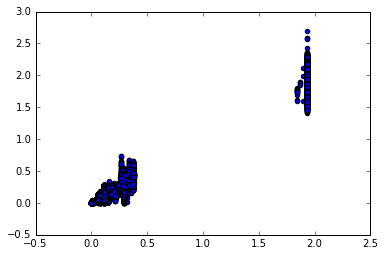

In [33]:
plt.scatter(y_predictions[:1000,:].flatten(), y[:1000,:].flatten())

In [30]:
y_predictions

array([[ 0.33784029,  0.13375935,  0.17646965, ...,  0.1082575 ,
         0.2669545 ,  0.30155233],
       [ 0.33784029,  0.13375935,  0.17646965, ...,  0.1082575 ,
         0.2669545 ,  0.30155233],
       [ 0.33784029,  0.13375935,  0.17646965, ...,  0.1082575 ,
         0.2669545 ,  0.30155233],
       ..., 
       [ 0.33784029,  0.13375935,  0.17646965, ...,  0.1082575 ,
         0.2669545 ,  0.30155233],
       [ 0.33784029,  0.13375935,  0.17646965, ...,  0.1082575 ,
         0.2669545 ,  0.30155233],
       [ 0.33784029,  0.13375935,  0.17646965, ...,  0.1082575 ,
         0.2669545 ,  0.30155233]])